In [1]:
from PEPit import PEP
from PEPit.operators import MonotoneOperator
from PEPit.primitive_steps import proximal_step
import numpy as np
from PEPit.function import Function
import matplotlib.pyplot as plt
import copy
import math
import time
import scipy
from pathlib import Path
import scipy.io
import seaborn as sns

%matplotlib inline

## Define the classes of $\rho$-comonotone and $\rho$-star comonotone operators

In [2]:
class NegativeComonotoneOperator(Function):
    def __init__(self,
                 rho=1.,
                 is_leaf=True,
                 decomposition_dict=None,
                 reuse_gradient=True):
        super().__init__(is_leaf=is_leaf,
                         decomposition_dict=decomposition_dict,
                         reuse_gradient=True)

        # Store the rho parameter
        self.rho = rho
        
    def add_class_constraints(self):

        for point_i in self.list_of_points:

            xi, gi, fi = point_i

            for point_j in self.list_of_points:

                xj, gj, fj = point_j

                if (xi != xj) | (gi != gj):
                    # Interpolation conditions of comonotone operator class
                    self.add_constraint((gi - gj) * (xi - xj) + self.rho * (gi - gj) ** 2 >= 0)
                    
class StarNegativeComonotoneOperator(Function):
    def __init__(self,
                 rho=1.,
                 is_leaf=True,
                 decomposition_dict=None,
                 reuse_gradient=True):
        super().__init__(is_leaf=is_leaf,
                         decomposition_dict=decomposition_dict,
                         reuse_gradient=True)

        # Store the rho parameter
        self.rho = rho
        
    def add_class_constraints(self):

        for point_i in self.list_of_stationary_points:

            xi, gi, fi = point_i

            for point_j in self.list_of_points:

                xj, gj, fj = point_j

                if point_i != point_j:
                    # Interpolation conditions of convex functions class
                    self.add_constraint(gj * (xj-xi) + self.rho *  gj ** 2 >= 0)

## Worst-case example

In [3]:
def wc_proximal_point(alpha, n, verbose=1):
    # Instantiate PEP
    problem = PEP()

    # Declare a negative comonotone operator
    A = problem.declare_function(NegativeComonotoneOperator)

    # Start by defining its unique optimal point xs = x_*
    xs = A.stationary_point()

    # Then define the starting point x0 of the algorithm and its gradient value g0
    x0 = problem.set_initial_point()

    # Set the initial constraint that is the distance between x0 and x^*
    problem.set_initial_condition((x0 - xs) ** 2 <= 1)

    # Compute n steps of the Proximal Gradient method starting from x0
    generated_sequence = np.array([x0])
    for i in range(n):
        x, _, _ = proximal_step(generated_sequence[i], A, alpha)
        generated_sequence = np.append(generated_sequence, x)

    # Set the performance metric to the distance between x(n) and x(n-1)
    problem.set_performance_metric((generated_sequence[-1] - generated_sequence[-2]) ** 2)

    # Solve the PEP
    pepit_verbose = max(verbose, 0)
    pepit_tau = problem.solve(verbose=pepit_verbose, dimension_reduction_heuristic="trace")

    
    # Print conclusion if required
    if verbose != -1:
        print('*** Example file: worst-case performance of the Proximal Point Method***')
        print('\tPEPit example:\t ||x^n - x^{n-1}||^2 == {:.6} ||x0 - xs||^2'.format(pepit_tau))

    generated_sequence_eval = np.real(np.array(np.real(generated_sequence[0].eval())))
    for i in range(n):
        generated_sequence_eval = np.vstack((generated_sequence_eval, np.real(generated_sequence[i+1].eval())))
    
    # Return the worst-case guarantee of the evaluated method
    return pepit_tau, generated_sequence_eval, xs.eval()

# Run the experiments and save the results

In [6]:
gamma_1 = 2.05
gamma_2 = 3
N_max = 60

In [ ]:
%%time

for i in range(1,N_max):
    if i == 47 or i == 57:
        continue
    _, generated_sequence_eval_1, xs_1 = wc_proximal_point(alpha=gamma_1, n=i+1, verbose=-1)
    _, generated_sequence_eval_2, xs_2 = wc_proximal_point(alpha=gamma_2, n=i+1, verbose=-1)
    print("N = ", i+1)
    with open('dump/sequence_PP_N_'+str(i)+'_gamma_1.npy', 'wb') as f:
        np.save(f, generated_sequence_eval_1)
    with open('dump/solution_PP_N_'+str(i)+'_gamma_1.npy', 'wb') as f:
        np.save(f, xs_1)
    with open('dump/sequence_PP_N_'+str(i)+'_gamma_2.npy', 'wb') as f:
        np.save(f, generated_sequence_eval_2)
    with open('dump/solution_PP_N_'+str(i)+'_gamma_2.npy', 'wb') as f:
        np.save(f, xs_2)

# Worst-case $\|F(x^N)\|^2$

In [7]:
worst_case_sq_norm_1 = np.array([])
worst_case_sq_norm_2 = np.array([])

N_array = np.array([])

lower_bound_1 = np.array([])
lower_bound_2 = np.array([])

upper_bound_1 = np.array([])
upper_bound_2 = np.array([])

for i in range(1, N_max):
    if i == 47 or i == 57:
        continue
        
    N_array = np.append(N_array, i)
    
    lower_bound_1 = np.append(lower_bound_1, 1.0 / (gamma_1*(gamma_1 - 2)*i*( (1+ 1.0/i)**(i+1) )))
    lower_bound_2 = np.append(lower_bound_2, 1.0 / (gamma_2*(gamma_2 - 2)*i*( (1+ 1.0/i)**(i+1) )))
    
    upper_bound_1 = np.append(upper_bound_1, 1.0 / (gamma_1*(gamma_1 - 2)*(i+1)))
    upper_bound_2 = np.append(upper_bound_2, 1.0 / (gamma_2*(gamma_2 - 2)*(i+1)))
    
    with open('dump/sequence_PP_N_'+str(i)+'_gamma_1.npy', 'rb') as f:
        sequence_1 = np.load(f)    
    sq_norm_1 = (np.linalg.norm(sequence_1[-1] - sequence_1[-2]) / gamma_1)**2
    worst_case_sq_norm_1 = np.append(worst_case_sq_norm_1, sq_norm_1)
    
    with open('dump/sequence_PP_N_'+str(i)+'_gamma_2.npy', 'rb') as f:
        sequence_2 = np.load(f)    
    sq_norm_2 = (np.linalg.norm(sequence_2[-1] - sequence_2[-2]) / gamma_2)**2
    worst_case_sq_norm_2 = np.append(worst_case_sq_norm_2, sq_norm_2)

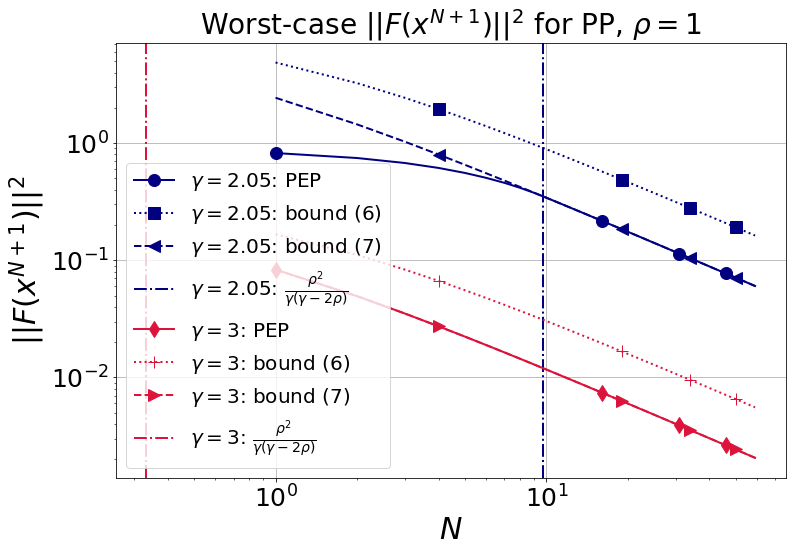

In [13]:
fig = plt.figure(figsize=(12,8))
plt.title(r"Worst-case $||F(x^{N+1})||^2$ for PP, $\rho = 1$", fontsize=28)

plt.semilogy(N_array, worst_case_sq_norm_1, linewidth=2,
             markersize = 12, marker = "o",
             markevery=range(0, len(N_array), 15), color="navy",
             label=r'$\gamma = 2.05$: PEP')
plt.semilogy(N_array, upper_bound_1, linewidth=2,
             markersize = 12, marker = "s", linestyle = "dotted",
             markevery=range(3, len(N_array), 15), color="navy",
             label=r'$\gamma = 2.05$: bound (6)')
plt.semilogy(N_array, lower_bound_1, linewidth=2,
             markersize = 12, marker = "<", linestyle = "dashed",
             markevery=range(3, len(N_array), 15), color="navy",
             label=r'$\gamma = 2.05$: bound (7)')

plt.axvline(x = 1 / (gamma_1 * (gamma_1 - 2)), color = 'navy', 
            linewidth=2, linestyle = "dashdot", label = r"$\gamma = 2.05$: $\frac{\rho^2}{\gamma(\gamma - 2\rho)}$")


plt.semilogy(N_array, worst_case_sq_norm_2, linewidth=2,
             markersize = 12, marker = "d",
             markevery=range(0, len(N_array), 15), color="crimson",
             label=r'$\gamma = 3$: PEP')
plt.semilogy(N_array, upper_bound_2, linewidth=2,
             markersize = 12, marker = "+", linestyle = "dotted",
             markevery=range(3, len(N_array), 15), color="crimson",
             label=r'$\gamma = 3$: bound (6)')
plt.semilogy(N_array, lower_bound_2, linewidth=2,
             markersize = 12, marker = ">", linestyle = "dashed",
             markevery=range(3, len(N_array), 15), color="crimson",
             label=r'$\gamma = 3$: bound (7)')

plt.axvline(x = 1 / (gamma_2 * (gamma_2 - 2)), color = 'crimson', 
            linewidth=2, linestyle = "dashdot", label = r"$\gamma = 3$: $\frac{\rho^2}{\gamma(\gamma - 2\rho)}$")


plt.legend(loc='best', fontsize=20)
plt.xlabel(r"$N$", fontsize=30)
plt.ylabel(r"$||F(x^{N+1})||^2$", fontsize=30)

plt.xticks(fontsize=25)
_ = plt.yticks(fontsize=25)

plt.grid()

ax = fig.gca()
ax.xaxis.offsetText.set_fontsize(28)
ax.yaxis.offsetText.set_fontsize(28)

ax.set_xscale('log')

plt.savefig("plot/PP_worst_case_norm.pdf", bbox_inches='tight')

# Verifying rotation

Here we verify that the worst-case operator given by PEP has form $F(x) = \alpha A x$ with $A = \begin{pmatrix} \cos\theta & -\sin\theta \\ \sin\theta & \cos\theta \end{pmatrix}$, $\alpha = \frac{|\cos \theta|}{\rho}$ for $\theta \in (\frac{\pi}{2}, \pi)$. Moreover, we want to verify that $\cos \theta = - \frac{\rho}{\sqrt{N\gamma(\gamma - 2\rho)}}$ for $N \geq \max\left\{\frac{\rho^2}{\gamma(\gamma-2\rho)},1\right\}$.

To show this we compute $\frac{\rho\|F(x^k)\|}{\|x^k - x^*\|}$ and $\frac{-\langle F(x^k), x^k - x^* \rangle}{\|F(x^k)\|\cdot\|x^k - x^*\|}$ for different runs of Proximal Point method (i.e., for different $N$ and $k = 1,\ldots,N+1$).

In [9]:
mean_norms_ratio_1 = np.array([])
std_norms_ratio_1 = np.array([])
mean_norms_ratio_2 = np.array([])
std_norms_ratio_2 = np.array([])

mean_minus_cosine_1 = np.array([])
std_minus_cosine_1 = np.array([])
mean_minus_cosine_2 = np.array([])
std_minus_cosine_2 = np.array([])

N_array = np.array([])
theoretical_value_1 = np.array([])
theoretical_value_2 = np.array([])

for i in range(1, N_max):
    if i == 47 or i == 57:
        continue
        
    N_array = np.append(N_array, i)
    theoretical_value_1 = np.append(theoretical_value_1, 1.0 / np.sqrt(i * gamma_1 * (gamma_1 - 2)))
    theoretical_value_2 = np.append(theoretical_value_2, 1.0 / np.sqrt(i * gamma_2 * (gamma_2 - 2)))
    
    with open('dump/sequence_PP_N_'+str(i)+'_gamma_1.npy', 'rb') as f:
        sequence_1 = np.load(f)
    with open('dump/solution_PP_N_'+str(i)+'_gamma_1.npy', 'rb') as f:
        xs_1 = np.load(f)
    operator_values_1 = np.array([(sequence_1[0] - sequence_1[1])/gamma_1])
    for k in range(i-2):
        operator_values_1 = np.vstack((operator_values_1, [(sequence_1[k+1] - sequence_1[k+2])/gamma_1]))
        
    norms_ratio_1 = np.array([])
    minus_cosine_1 = np.array([])
    
    for k in range(len(operator_values_1)):
        norm_operator = np.linalg.norm(operator_values_1[k])
        distance_to_xs = np.linalg.norm(sequence_1[k+1]-xs_1)
        inner_product = operator_values_1[k].dot(sequence_1[k+1]-xs_1)
        norms_ratio_1 = np.append(norms_ratio_1, norm_operator / distance_to_xs)
        minus_cosine_1 = np.append(minus_cosine_1, - inner_product / (norm_operator * distance_to_xs))
        
    mean_norms_ratio_1 = np.append(mean_norms_ratio_1, np.mean(norms_ratio_1))
    std_norms_ratio_1 = np.append(std_norms_ratio_1, np.std(norms_ratio_1))
    mean_minus_cosine_1 = np.append(mean_minus_cosine_1, np.mean(minus_cosine_1))
    std_minus_cosine_1 = np.append(std_minus_cosine_1, np.std(minus_cosine_1))
    
    
    
    with open('dump/sequence_PP_N_'+str(i)+'_gamma_2.npy', 'rb') as f:
        sequence_2 = np.load(f)    
    with open('dump/solution_PP_N_'+str(i)+'_gamma_2.npy', 'rb') as f:
        xs_2 = np.load(f)
    operator_values_2 = np.array([(sequence_2[0] - sequence_2[1])/gamma_2])
    for k in range(i-2):
        operator_values_2 = np.vstack((operator_values_2, [(sequence_2[k+1] - sequence_2[k+2])/gamma_2]))
        
    norms_ratio_2 = np.array([])
    minus_cosine_2 = np.array([])
    
    for k in range(len(operator_values_2)):
        norm_operator = np.linalg.norm(operator_values_2[k])
        distance_to_xs = np.linalg.norm(sequence_2[k+1]-xs_2)
        inner_product = operator_values_2[k].dot(sequence_2[k+1]-xs_2)
        norms_ratio_2 = np.append(norms_ratio_2, norm_operator / distance_to_xs)
        minus_cosine_2 = np.append(minus_cosine_2, - inner_product / (norm_operator * distance_to_xs))
        
    mean_norms_ratio_2 = np.append(mean_norms_ratio_2, np.mean(norms_ratio_2))
    std_norms_ratio_2 = np.append(std_norms_ratio_2, np.std(norms_ratio_2))
    mean_minus_cosine_2 = np.append(mean_minus_cosine_2, np.mean(minus_cosine_2))
    std_minus_cosine_2 = np.append(std_minus_cosine_2, np.std(minus_cosine_2))    

In [10]:
print(np.max(std_norms_ratio_1))
print(np.max(std_norms_ratio_2))
print(np.max(std_minus_cosine_1))
print(np.max(std_minus_cosine_2))

1.1146218409164179e-07
1.6273007134077691e-07
1.2504321898456409e-07
2.09219422915762e-06


The code above illustrates that estimated values $\frac{\rho\|F(x^k)\|}{\|x^k - x^*\|}$ and $\frac{-\langle F(x^k), x^k - x^* \rangle}{\|F(x^k)\|\cdot\|x^k - x^*\|}$ (based on PEP output) remain almost the same during the run of the method.

Next, we verify that both of these values are close to $\frac{\rho}{\sqrt{N\gamma(\gamma - 2\rho)}}$

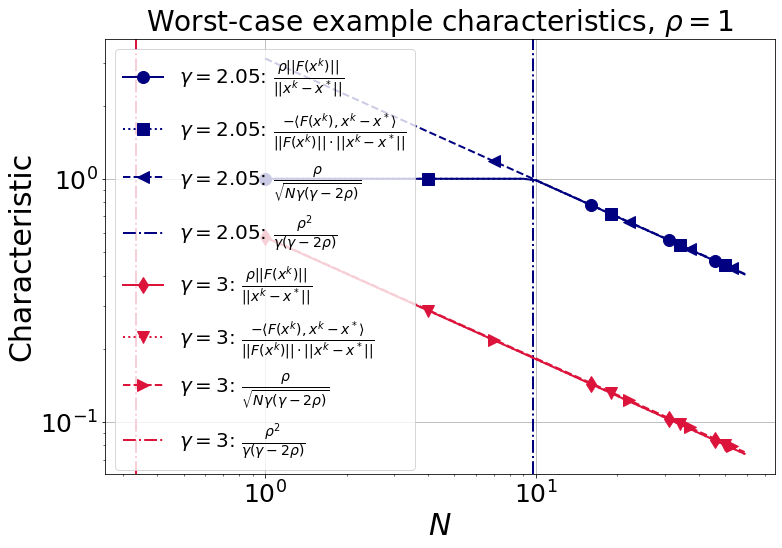

In [14]:
fig = plt.figure(figsize=(12,8))
plt.title(r"Worst-case example characteristics, $\rho = 1$", fontsize=28)

plt.semilogy(N_array, mean_norms_ratio_1, linewidth=2,
             markersize = 12, marker = "o",
             markevery=range(0, len(N_array), 15), color="navy",
             label=r'$\gamma = 2.05$: $\frac{\rho||F(x^k)||}{||x^k - x^*||}$')
plt.semilogy(N_array, mean_minus_cosine_1, linewidth=2,
             markersize = 12, marker = "s", linestyle = "dotted",
             markevery=range(3, len(N_array), 15), color="navy",
             label=r'$\gamma = 2.05$: $\frac{-\langle F(x^k), x^k - x^* \rangle}{||F(x^k)||\cdot||x^k - x^*||}$')
plt.semilogy(N_array, theoretical_value_1, linewidth=2,
             markersize = 12, marker = "<", linestyle = "dashed",
             markevery=range(6, len(N_array), 15), color="navy",
             label=r'$\gamma = 2.05$: $\frac{\rho}{\sqrt{N\gamma(\gamma - 2\rho)}}$')

plt.axvline(x = 1 / (gamma_1 * (gamma_1 - 2)), color = 'navy', 
            linewidth=2, linestyle = "dashdot", label = r"$\gamma = 2.05$: $\frac{\rho^2}{\gamma(\gamma - 2\rho)}$")


plt.semilogy(N_array, mean_norms_ratio_2, linewidth=2,
             markersize = 12, marker = "d",
             markevery=range(0, len(N_array), 15), color="crimson",
             label=r'$\gamma = 3$: $\frac{\rho ||F(x^k)||}{||x^k - x^*||}$')
plt.semilogy(N_array, mean_minus_cosine_2, linewidth=2,
             markersize = 12, marker = "v", linestyle = "dotted",
             markevery=range(3, len(N_array), 15), color="crimson",
             label=r'$\gamma = 3$: $\frac{-\langle F(x^k), x^k - x^* \rangle}{||F(x^k)||\cdot||x^k - x^*||}$')
plt.semilogy(N_array, theoretical_value_2, linewidth=2,
             markersize = 12, marker = ">", linestyle = "dashed",
             markevery=range(6, len(N_array), 15), color="crimson",
             label=r'$\gamma = 3$: $\frac{\rho}{\sqrt{N\gamma(\gamma - 2\rho)}}$')

plt.axvline(x = 1 / (gamma_2 * (gamma_2 - 2)), color = 'crimson', 
            linewidth=2, linestyle = "dashdot", label = r"$\gamma = 3$: $\frac{\rho^2}{\gamma(\gamma - 2\rho)}$")


plt.legend(loc='best', fontsize=20)
plt.xlabel(r"$N$", fontsize=30)
plt.ylabel(r"Characteristic", fontsize=30)

plt.xticks(fontsize=25)
_ = plt.yticks(fontsize=25)

plt.grid()

ax = fig.gca()
ax.xaxis.offsetText.set_fontsize(28)
ax.yaxis.offsetText.set_fontsize(28)

ax.set_xscale('log')

plt.savefig("plot/PP_worst_case_characteristics.pdf", bbox_inches='tight')